## 4차 프로그래밍 과제 20200818_이강산

### I. 문제 정의

* 데이터 셋 “machine.data_update.csv ” 기반으로 CPU 성능에 관련된 다양한 특징들을 이용하여 CPU의 성능을 예측하는 회귀 분석 모델링하시오. 

IV. 4차 프로그래밍과제 구현 내용

(1) II. 데이터 셋에서 주어진 특징들을 선택하여 CPU 성능 즉, “PRP” 변수를 예측하는 Pipeline 기반 다중 회귀 모델링을 프로그래밍 하시오.
- 데이터 탐색 및 시각화, 전처리, 훈련 데이터와 테스트 데이터 분리, 하이퍼파라미터 튜닝, 훈련 데이터 앙상블 학습 과정, 교차 검증, 분석 결과 시각화 등을 포함하여 최적화하는 전체 과정을 포함하시오.

(2) (1) 단계에서 얻은 Pipeline 기반 모델 GridSearchCV의 best_estimator모델을 사용하여 학습 데이터와 테스트 데이터 각각에 대해 이 모델의 성능을 평가하시오.
- Mean squared Error, Mean absolute Error, R^2, 교차검증

(3) (2) 단계에서 얻은 Pipeline 기반 GridSearchCV의 best_estimator모델의 테스트 데이터에 대해 예측 성능 R^2가 85% 이상이 나오도록 모델을 개선하시오.

(4) I. 3차 프로그래밍 과제의 기본모델의 (2) 단계와 II. 4차 프로그래밍 과제의 제안 모델의 (2) 단계에서 얻은 학습 데이터와 테스트 데이터에 대한 성능 지표(MSE, MAE, R^2, 교차 검증)를 데이터프레임에 저장하여 이 성능 결과를 바 차트로 시각화하여 학습 데이터와 테스트 데이터에 대한 각 모델의 성능 차이를 비교 분석하시오.
예시)
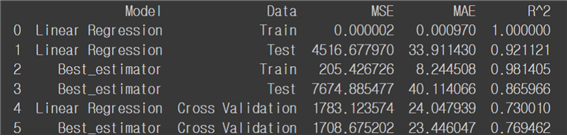
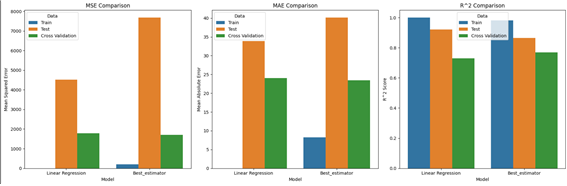



(5) (1), (2), (3), (4) 단계 전 과정을 포함한 전체 프로그래밍을 소스파일 “pipeline_cpu_data.ipynb”로 작성해서 사이버캠퍼스 “4차 프로그래밍과제”와 github에 각각 업로드 하시오.

### 라이브러리 임포트

In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.000000   4000.000000    0.000000    1.000000   
50%     110.000000   2000.000000   8000.000000    8.000000    2.000000   
75%     225.000000   4000.000000  16000.000000   32.000000    6.000000   
max    1500.000000  32000.000000  64000.000000  256.000000   52.000000   

            CHMAX          PRP          ERP  
count  209.000000   209.000000   209.000000  
mean    18.267943   105.622010    99.330144  
std     25.997318   160.830733   154.757102  
min      0.000000     6.000000    15.000000  
25%      5.000000    27.000000    28.000000  
50%      8.000000    50.000000    45.000000  
75%     24.

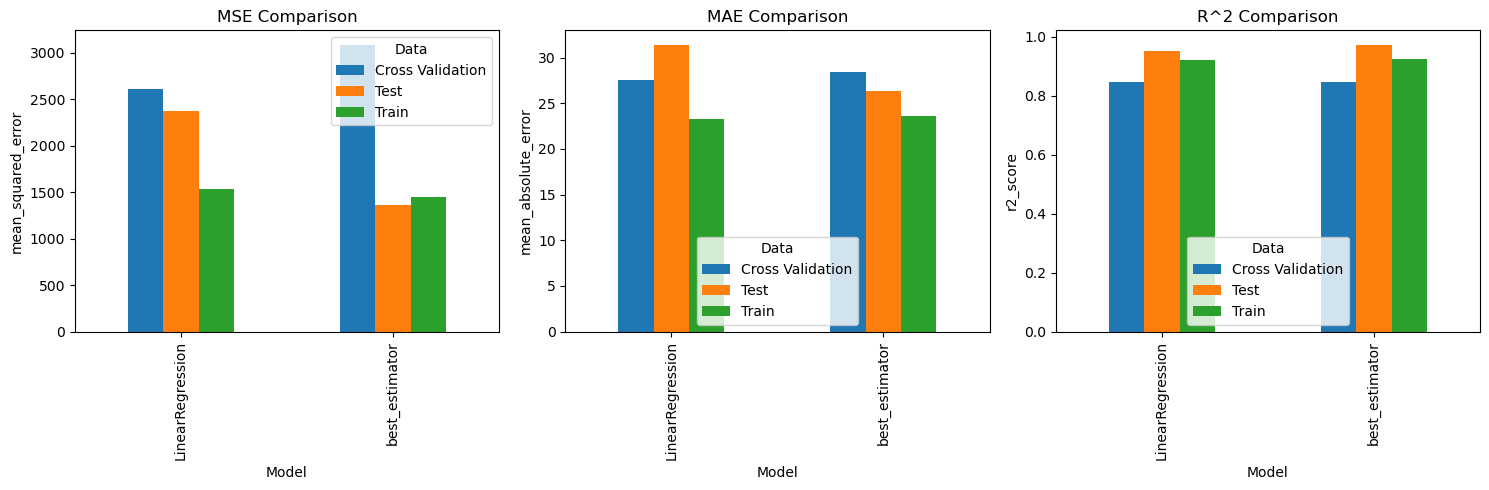

In [2]:
# 데이터 로드
df = pd.read_csv('machine.data_update.csv')

# 타겟 변수 (PRP)와 특징 정의
X = df.drop(['PRP', 'VendorName', 'ModelName'], axis=1)
y = df['PRP']

# 데이터 탐색 및 전처리
print(df.describe())
print(df.isnull().sum())  # 누락된 값 확인

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 파이프라인 구성 및 모델 생성
models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor(random_state=42)),
    ('ridge', Ridge(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
]
ensemble = VotingRegressor(estimators=models)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ensemble', ensemble)
])

# 하이퍼파라미터 튜닝
params_grid = {
    'ensemble__lr__fit_intercept': [True, False],
    'ensemble__sgd__alpha': [0.0001, 0.001, 0.01],
    'ensemble__ridge__alpha': [1.0, 10.0, 100.0],
    'ensemble__gbr__n_estimators': [100, 200],
    'ensemble__gbr__learning_rate': [0.01, 0.1]
}
grid_search = GridSearchCV(pipeline, params_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# 최적 파라미터와 점수 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# 기본 모델 학습 및 예측
basic_model = LinearRegression()
basic_model.fit(X_train, y_train)
basic_train_pred = basic_model.predict(X_train)
basic_test_pred = basic_model.predict(X_test)

# 제안 모델 학습 및 예측
best_model = grid_search.best_estimator_
proposed_train_pred = best_model.predict(X_train)
proposed_test_pred = best_model.predict(X_test)

# 성능 지표 계산
performance_data = {
    'Model': ['LinearRegression', 'LinearRegression', 'best_estimator', 'best_estimator', 'LinearRegression', 'best_estimator'],
    'Data': ['Train', 'Test', 'Train', 'Test', 'Cross Validation', 'Cross Validation'],
    'MSE': [
        mean_squared_error(y_train, basic_train_pred),
        mean_squared_error(y_test, basic_test_pred),
        mean_squared_error(y_train, proposed_train_pred),
        mean_squared_error(y_test, proposed_test_pred),
        -cross_val_score(basic_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean(),
        -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    ],
    'MAE': [
        mean_absolute_error(y_train, basic_train_pred),
        mean_absolute_error(y_test, basic_test_pred),
        mean_absolute_error(y_train, proposed_train_pred),
        mean_absolute_error(y_test, proposed_test_pred),
        -cross_val_score(basic_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean(),
        -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    ],
    'R^2': [
        r2_score(y_train, basic_train_pred),
        r2_score(y_test, basic_test_pred),
        r2_score(y_train, proposed_train_pred),
        r2_score(y_test, proposed_test_pred),
        cross_val_score(basic_model, X_train, y_train, cv=5, scoring='r2').mean(),
        cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2').mean()
    ]
}

# 데이터프레임 생성 및 결과 출력
results_df = pd.DataFrame(performance_data).drop_duplicates()
print(results_df)

# 막대그래프를 사용한 성능 비교 시각화
metrics = ['MSE', 'MAE', 'R^2']
titles = ['MSE Comparison', 'MAE Comparison', 'R^2 Comparison']
ylabels = ['mean_squared_error', 'mean_absolute_error', 'r2_score']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    results_df.pivot(index='Model', columns='Data', values=metric).plot(kind='bar', ax=axs[i])
    axs[i].set_title(titles[i])
    axs[i].set_ylabel(ylabels[i])

plt.tight_layout()
plt.show()
